# Lab 5: Hitters (R)

In the computational section of this Lab you will consider the baseball dataset found in the file hitters.csv. This dataset records the salary of 𝑛 = 263 Major League Baseball players during the 1987 season as well as 𝑞 = 19 statistics associated with the performance of each player during the previous season. Specifically, the dataset contains observations from the following variables:
* AtBat: Number of times at bat in 1986
* Hits: Number of hits in 1986
* HmRun: Number of home runs in 1986
* Runs: Number of runs in 1986
* RBI: Number of runs batted in in 1986
* Walks: Number of walks in 1986
* Years: Number of years in the major leagues
* CAtBat: Number of times at bat during his career
* CHits: Number of hits during his career
* CHmRun: Number of home runs during his career
* CRuns: Number of runs during his career
* CRBI: Number of runs batted in during his career
* CWalks: Number of walks during his career
* League: A categorical variable with levels A (for American) and N (for National) indicating the player’s league at the end of 1986
* Division: A factor with levels E (for East) and W (for West) indicating the player’s division at the end of 1986
* PutOuts: Number of put outs in 1986
* Assists: Number of assists in 1986
* Errors: Number of errors in 1986
* Salary: 1987 annual salary on opening day in thousands of dollars
* NewLeague: A factor with levels A and N indicating the player’s league at the beginning of 1987

In [35]:
library(car)
library(leaps)
library(MASS)
library(boot, quietly = T)
data <- read.csv(file = "hitters.csv", header = T)


Attaching package: ‘boot’

The following object is masked from ‘package:car’:

    logit



(a) Calculate the variance inflation factor (VIF) for each of the explanatory variables.Comment on whether multicollinearity appears to be an issue. If it is, identify the three explanatory variables that are most seriously affected by the issue.

In [13]:
fullModel <- lm(Salary ~ ., data = data)
sort(vif(fullModel))

Division    PutOuts     Errors    Assists  NewLeague     League      Walks 
  1.075398   1.236317   2.214543   2.709341   4.099063   4.134115   4.148712 
     HmRun      Years        RBI       Runs     CWalks      AtBat       Hits 
  7.758668   9.313280  11.921715  15.246418  19.744105  22.944366  30.281255 
    CHmRun       CRBI      CRuns     CAtBat      CHits 
 46.488462 131.965858 162.520810 251.561160 502.954289

Based on the VIFs that were calculated above, we can see that multicollinearity is an issue. The top variables that are seriously affectd by this issue are: CRBI, CRuns, CAtBat, and Chits. These all have large VIFs, but this is not suprising since the # of runs scored and RBIs ina player's career are both going to be highly correlated with the # of hits the player gets in their career. And these will be highly correlated with # of times a player gets to bat in their career.

(b) Using the all-possible-subsets approach, find the model that best fits the observed data. This procedure may be automated using the regsubsets() function in R, but you must explain in your own words how this algorithm identifies the ‘best' model. Note that you do not need to perform this task in Python.

[1] 11

(Intercept)       AtBat        Hits       HmRun        Runs         RBI 
       TRUE        TRUE        TRUE       FALSE       FALSE       FALSE 
      Walks       Years      CAtBat       CHits      CHmRun       CRuns 
       TRUE       FALSE        TRUE       FALSE       FALSE        TRUE 
       CRBI      CWalks     LeagueN   DivisionW     PutOuts     Assists 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
     Errors  NewLeagueN 
      FALSE       FALSE


Call:
lm(formula = Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + 
    CRBI + CWalks + League + Division + PutOuts + Assists, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-932.2 -175.4  -29.2  130.4 1897.2 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  135.75122   71.34623   1.903 0.058223 .  
AtBat         -2.12775    0.53746  -3.959 9.81e-05 ***
Hits           6.92370    1.64612   4.206 3.62e-05 ***
Walks          5.62028    1.59064   3.533 0.000488 ***
CAtBat        -0.13899    0.05609  -2.478 0.013870 *  
CRuns          1.45533    0.39270   3.706 0.000259 ***
CRBI           0.78525    0.20978   3.743 0.000225 ***
CWalks        -0.82286    0.26361  -3.121 0.002010 ** 
LeagueN       43.11162   39.96612   1.079 0.281755    
DivisionW   -111.14603   39.21835  -2.834 0.004970 ** 
PutOuts        0.28941    0.07478   3.870 0.000139 ***
Assists        0.26883    0.15816   1.700 0.090430 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 

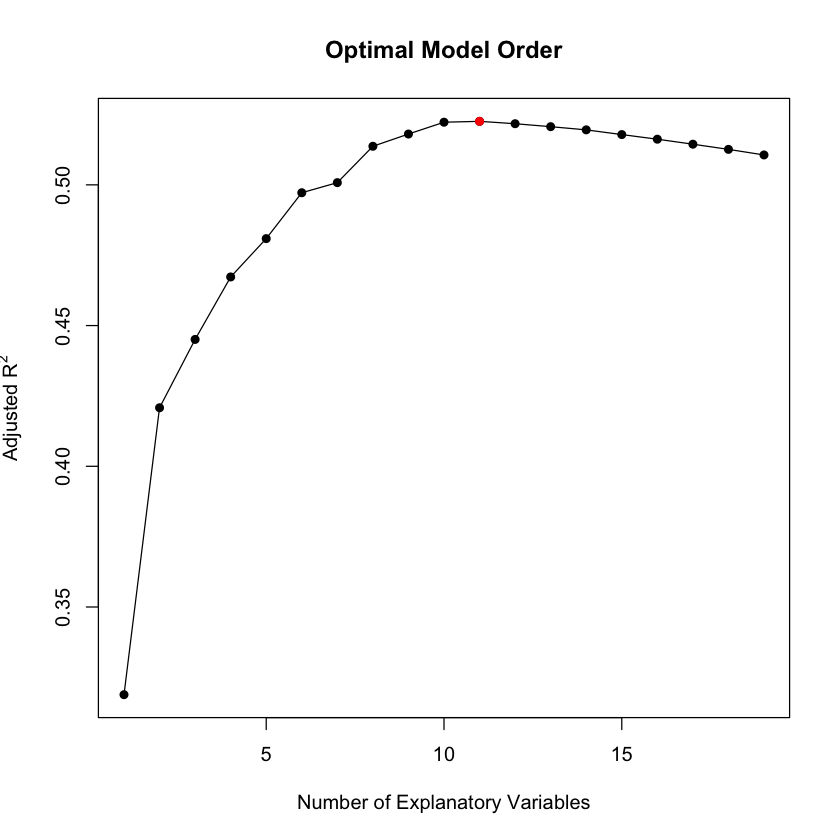

In [15]:
all_poss <- regsubsets(Salary ~ ., data = data, nvmax = 19)
all_poss_summ <- summary(all_poss)
plot(all_poss_summ$adjr2, type = "l", xlab = "Number of Explanatory Variables", ylab = bquote("Adjusted R"^2), main = "Optimal Model Order")
points(all_poss_summ$adjr2, pch = 16)
max_idx <- which.max(all_poss_summ$adjr2)
max_idx
points(x = max_idx, y = all_poss_summ$adjr2[max_idx], pch = 16, col = "red")
all_poss_summ$which[max_idx,]
m_ap <- lm(Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + League + Division + PutOuts + Assists, data = data)
summary(m_ap)

The "all possible subsets", finds the best model by fittting all 2^19 (2^q) possible models and for a given # of explanatroy variables, uses R^2 to find the best model which is the model with the highest R^2. Now that we have 19 optimal models, from these we choose the model with the largest R^2adj. Based on the results above, our best model here has 11 explanatory varibales: AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalks, League, Division, PutOuts, and Assists.

(c) Using the forward-stepwise-selection approach, find the model that best fits the observed data. This procedure may be automated using the stepAIC() function in R, but you must explain in your own words how this algorithm identifies the ‘best’ model. Note that you do not need to perform this task in Python.

In [17]:
small <- lm(Salary ~ 1, data = data)
large <- lm(Salary ~ ., data = data)
forwardModel <- stepAIC(object = small, scope = list(upper = large, lower = small), direction = "forward", trace = 0)
summary(forwardModel)


Call:
lm(formula = Salary ~ CRBI + Hits + PutOuts + Division + AtBat + 
    Walks + CWalks + CRuns + CAtBat + Assists, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-939.11 -176.87  -34.08  130.90 1910.55 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  162.53544   66.90784   2.429 0.015830 *  
CRBI           0.77431    0.20961   3.694 0.000271 ***
Hits           6.91802    1.64665   4.201 3.69e-05 ***
PutOuts        0.29737    0.07444   3.995 8.50e-05 ***
DivisionW   -112.38006   39.21438  -2.866 0.004511 ** 
AtBat         -2.16865    0.53630  -4.044 7.00e-05 ***
Walks          5.77322    1.58483   3.643 0.000327 ***
CWalks        -0.83083    0.26359  -3.152 0.001818 ** 
CRuns          1.40825    0.39040   3.607 0.000373 ***
CAtBat        -0.13008    0.05550  -2.344 0.019858 *  
Assists        0.28317    0.15766   1.796 0.073673 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 311.8

In "forward selection" we start by considering all possible simple linear regressions containing just one of each of the  q=19  explanatory variables. We then look at the AIC values for each of these models, where the model with the smallest AIC value is the best. This continues, each time considering all possible models that could be created by adding one of the remaining explanatory variables into the current 'optimal' model. Before the next step, the model with the lowest AIC moves onto the next step. If at any step we can no longer add the model with the smallest AIC then this alogorithm stops and the model from the previous step is the 'optimal' model. Based on the results above our 'optimal' model using forward selection has the following explanatory varibales in order: CRBI, Hits, PutOuts, DivisionW, AtBat, Walks, CWalks, CRuns, CAtBat, and Assists.

(d) Using the backward-stepwise-selection approach, find the model that best fits the observed data. This procedure may be automated using the stepAIC() function in R, but you must explain in your own words how this algorithm identifies the ‘best’ model. Note that you do not need to perform this task in Python.

In [18]:
backwardModel <- stepAIC(object = large, scope = list(upper = large, lower = small), direction = "backward", trace = 0)
summary(backwardModel)


Call:
lm(formula = Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + 
    CRBI + CWalks + Division + PutOuts + Assists, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-939.11 -176.87  -34.08  130.90 1910.55 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  162.53544   66.90784   2.429 0.015830 *  
AtBat         -2.16865    0.53630  -4.044 7.00e-05 ***
Hits           6.91802    1.64665   4.201 3.69e-05 ***
Walks          5.77322    1.58483   3.643 0.000327 ***
CAtBat        -0.13008    0.05550  -2.344 0.019858 *  
CRuns          1.40825    0.39040   3.607 0.000373 ***
CRBI           0.77431    0.20961   3.694 0.000271 ***
CWalks        -0.83083    0.26359  -3.152 0.001818 ** 
DivisionW   -112.38006   39.21438  -2.866 0.004511 ** 
PutOuts        0.29737    0.07444   3.995 8.50e-05 ***
Assists        0.28317    0.15766   1.796 0.073673 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 311.8

In "backward selection", we first fit the full model which has q = 19 explanatory variables. Now we should consider all possible models if one of the explanatory variables were removed. We choose the best model with the smallest AIC value. We repreat this process until each time by removing an explanatory varibale from the current 'optimal' model. At every step we keep the model with the smallest AIC value. And if at any stage we can no longer remove explanatory varibales (AIC value is never smaller) then we keep the model from th previous step ad stop the alogrithm. The results in this case as we see above show that the optimal model contains the following explanatory varibales: AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalks, DivisionW, PutOuts and Assists. Note: That this is the same model that resulted from forward selection in part(d).

(e) Using the hybrid-stepwise-selection approach, find the model that best fits the observed data. This procedure may be automated using the stepAIC() function in R, but you must explain in your own words how this algorithm identifies the ‘best’ model. Note that you do not need to perform this task in Python.

In [19]:
hybridModel <- stepAIC(object = small, scope = list(upper = large, lower = small), direction = "both", trace = 0)
summary(hybridModel)


Call:
lm(formula = Salary ~ CRBI + Hits + PutOuts + Division + AtBat + 
    Walks + CWalks + CRuns + CAtBat + Assists, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-939.11 -176.87  -34.08  130.90 1910.55 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  162.53544   66.90784   2.429 0.015830 *  
CRBI           0.77431    0.20961   3.694 0.000271 ***
Hits           6.91802    1.64665   4.201 3.69e-05 ***
PutOuts        0.29737    0.07444   3.995 8.50e-05 ***
DivisionW   -112.38006   39.21438  -2.866 0.004511 ** 
AtBat         -2.16865    0.53630  -4.044 7.00e-05 ***
Walks          5.77322    1.58483   3.643 0.000327 ***
CWalks        -0.83083    0.26359  -3.152 0.001818 ** 
CRuns          1.40825    0.39040   3.607 0.000373 ***
CAtBat        -0.13008    0.05550  -2.344 0.019858 *  
Assists        0.28317    0.15766   1.796 0.073673 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 311.8

In "hybrid-stepwise-selection" is basically forward and backward selection combined. What I mean by this is that say we start with forward selection then we would continue the foward slection algorithm, the only difference here is that at every step once we've added the best explanatory varibale then we will also be checking if the model can be impoved by removing any explanatory varibales. Now, if we start with backward selection then we would continue the backward slelection algorithm, the only differnece here is that at every step once the least important explanatory varibale is removed then we will also be checking is any explanatory varibales that are NOT in the model should be added back in. In both cases, we will continue alternating until we can no longer add or remove explanatory varibales (aka the AIC will no longer decrease). The results in this case as we see above show that the optimal model contains the following explanatory varibales: CRBI, Hits, PutOuts, DivisionW, AtBat, Walks, CWalks, CRuns, CAtBat, and Assists. Note: That every stepwise selection alogirhtm results in the same 'optimal' model.

(f) In this part you will compare the predictive performance of four models:

* i. The full model with all 19 explanatory variables.
* ii. The optimal model identified in part (b).
* iii. The best model from parts (c)-(e) (i.e., the best stepwise-selection model).
* iv. The model that is considered optimal with respect to the Bayesian Information Criterion (BIC) which contains the variables AtBat, Hits, Walks, CRBI, Division and PutOuts.

Randomly split the observed data into a training set (containing roughly 80% of all of the data) and a held-out test set (containing roughly 20% of all of the data). Calculate the predictive root-mean-square error (RMSE) for each of the four models. Which model appears to be most appropriate? Justify why this model is most appropriate.

In [34]:
n <- dim(data)[1]
trn <- sample(x = c(rep(TRUE, round(0.8*n)), rep(FALSE, n-round(0.8*n))), size = n, replace = FALSE)
train <- data[trn,]
tst <- !trn 
test <- data[tst,]

#i. The full model with all 19 explanatory variables.
model1 <- lm(Salary ~ ., data = data)
pred1 <- predict(object = model1, newdata = test)
RMSE1 <- sqrt(mean((test$Salary - pred1)^2))
paste("The predictive RMSE for the full model is ", round(RMSE1, 4), sep = "")

#ii. The optimal model identified in part (b).
model2 <- lm(Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + League + Division + PutOuts + Assists, data = train)
pred2 <- predict(object = model2, newdata = test)
RMSE2 <- sqrt(mean((test$Salary - pred2)^2))
paste("The predictive RMSE for the optimal model from part (b) is ", round(RMSE2, 4), sep = "")

#iii. The best model from parts (c)-(e) (i.e., the best stepwise-selection model).
model3 <- lm(Salary ~ CRBI + Hits + PutOuts + Division + AtBat + Walks + CWalks + CRuns + CAtBat + Assists, data = train)
pred3 <- predict(object = model3, newdata = test)
RMSE3 <- sqrt(mean((test$Salary - pred3)^2))
paste("The predictive RMSE for the best model selected by stepwise selection is ", round(RMSE3, 4), sep = "")

#iv. The model that is considered optimal with respect to the Bayesian Information Criterion (BIC) which contains the variables AtBat, Hits, Walks, CRBI, Division and PutOuts.
model4 <- lm(Salary ~ AtBat + Hits + Walks + CRBI + Division + PutOuts, data = train)
pred4 <- predict(object = model4, newdata = test)
RMSE4 <- sqrt(mean((test$Salary - pred4)^2))
paste("The predictive RMSE for the optimal model (in terms of BIC) is ", round(RMSE4, 4), sep = "")

[1] "The predictive RMSE for the full model is 279.8718"

[1] "The predictive RMSE for the optimal model from part (b) is 297.6638"

[1] "The predictive RMSE for the best model selected by stepwise selection is 299.3206"

[1] "The predictive RMSE for the optimal model (in terms of BIC) is 319.4919"

Based on the RMSE, the best predicitive model is the full model since it has the smallest RMSE. In contrast, the worst predicitive model is the optimal BIC model since it has the largest RMSE. And both the optimal model from part (b) and the stepwise selection mdoel perform similarly since the difference between both there RMSE values is very small.

(g) As in part (f), you must compare the predictive performance of the same four models, but here you must determine the predictive accuracy (predictive RMSE) by using 10-Fold Cross Validation. Which model appears to be most appropriate? Justify why this model is most appropriate.

In [39]:
#i. The full model with all 19 explanatory variables.
model1 <- glm(Salary ~ ., data = data)
RMSE1 <- sqrt((cv.glm(data, model1, K = 10)$delta)[1])
paste("The predictive RMSE for the full model is ", round(RMSE1, 4), sep = "")

#ii. The optimal model identified in part (b).
model2 <- glm(Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + League + Division + PutOuts + Assists, data = data)
RMSE2 <- sqrt((cv.glm(data, model2 , K = 10)$delta)[1])
paste("The predictive RMSE for the optimal model from part (b) is ", round(RMSE2, 4), sep = "")

#iii. The best model from parts (c)-(e) (i.e., the best stepwise-selection model).
model3 <- glm(Salary ~ CRBI + Hits + PutOuts + Division + AtBat + Walks + CWalks + CRuns + CAtBat + Assists, data = data)
RMSE3 <- sqrt((cv.glm(data, model3, K = 10)$delta)[1])
paste("The predictive RMSE for the best model selected by stepwise selection is ", round(RMSE3, 4), sep = "")

#iv. The model that is considered optimal with respect to the Bayesian Information Criterion (BIC) which contains the variables AtBat, Hits, Walks, CRBI, Division and PutOuts.
model4 <- glm(Salary ~ AtBat + Hits + Walks + CRBI + Division + PutOuts, data = data)
RMSE4 <- sqrt((cv.glm(data, model4, K = 10)$delta)[1])
paste("The predictive RMSE for the optimal model (in terms of BIC) is ", round(RMSE4, 4), sep = "")

[1] "The predictive RMSE for the full model is 338.8668"

[1] "The predictive RMSE for the optimal model from part (b) is 330.5222"

[1] "The predictive RMSE for the best model selected by stepwise selection is 331.778"

[1] "The predictive RMSE for the optimal model (in terms of BIC) is 329.4752"

Based on the RMSE, the best predicitive model is the optimal BIC model since it has the smallest RMSE. In contrast, the worst predicitive model is the full model since it has the largest RMSE. And both the optimal model from part (b) and the stepwise selection mdoel perform similarly since the difference between both there RMSE values is very small.

(h) Given the estimates of predictive accuracy from parts (f) and (g) indicate which estimates you believe to be more accurate. In other words, indicate which validation approach (i.e., cross validation vs. k-fold cross validation) you believe will most accurately estimate the predictive capability of a model. Briefly explain your rationale.

In our case, we see that the 10-fold cross validation uses all of the data provided and giving us a more accurate predictive model. Therefore, the k-fold corss validation estimates are more accurate than cross validation since k-cross validation follows the 80-20 parition we want instead of individual partitions like in cross validation.

(i) Accounting for all of the analyses you’ve performed (i.e., multicollinearity, goodness-of-fit, and predictive accuracy), which model would you be most comfortable using? Briefly justify your choice. [Note: I’m not looking for a right or wrong answer here; I want to see that you can sensibly and eloquently justify your choice].

I'd be more comfortable using the optimal BIC model since we see in part (g) that it is the best predictive model when using 10-fold cross validation which we discussed in (h) has the best accuracy over cross-validation results. Another reason for this decision is that the optimal BIC model is also protected from multicollinearity compared to other models. This protection comes from the model only containing one of the multicollinear explanatory varibales.